In [1]:
# Import relevant libraries
import os #computer stuff
import numpy as np
import matplotlib.pyplot as plt #plots
import pandas as pd #to work with datasets
from zipfile import ZipFile
import os

import mne
import mne_nirs

# Import StatsModels
import statsmodels.formula.api as smf
import tqdm


from mne_nirs.experimental_design import make_first_level_design_matrix #making design matrices
from mne_nirs.statistics import run_glm #making ocntrasts
from mne_nirs.statistics import statsmodels_to_results
from mne_nirs.visualisation import plot_glm_group_topo
from mne_nirs.visualisation import plot_glm_surface_projection
from mne_nirs.channels import (get_long_channels, 
                               get_short_channels,
                               picks_pair_to_idx) 
from mne.preprocessing.nirs import optical_density, beer_lambert_law

from nilearn.plotting import plot_design_matrix #another project before mne nirs, they are using it for plotting design matrices

from itertools import compress #for loops, iterations in general
from icecream import ic #like "print"

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids, get_entity_vals

import matplotlib as mpl
from lets_plot import *
LetsPlot.setup_html()

from plotnine import ggplot, aes, geom_line, geom_point, facet_grid, geom_hline
import surfer

print('packages have been imported')

/Users/sigridagersnapbomnielsen/opt/anaconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/Users/sigridagersnapbomnielsen/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


packages have been imported


# Main functions
The following is the preprocessing and the analysis function.

In [108]:
def preprocess(raw_intensity, verbose=False):
    """
    Loads the raw data from the path and procesess it
    """
    # if verbose:
    #     ic("Loading ", path)
    # raw_intensity = mne.io.read_raw_snirf(raw_path, preload=True)

    # converting to optical density
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

    # creating SCI
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)

    # naming 'bad channels'
    raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.2))

    # interpolation
    ic("Interpolate bad channels.")
    raw_od.interpolate_bads(reset_bads = False, method = dict(fnirs = 'nearest'))
    
    #old .scalp_coupling_index(raw_od, l_freq=0.7, h_freq=1.5)
    
    # if verbose:
    ic("Apply short channel regression.")
    od_corrected = mne_nirs.signal_enhancement.short_channel_regression(raw_od)

    if verbose:
        ic("Do temporal derivative distribution repair on:", od_corrected)
    tddr_od = mne.preprocessing.nirs.tddr(od_corrected)

    if verbose:
        ic("Convert to haemoglobin with the modified beer-lambert law.")
    raw_haemo = beer_lambert_law(tddr_od, ppf=0.1)

    #if verbose:
    #    ic("Apply further data cleaning techniques")
    #raw_haemo = mne_nirs.signal_enhancement.enhance_negative_correlation(
    #    raw_haemo)

    # if verbose:
    # ic("Bandpass filter on:", raw_haemo)
    # Esben's values
    #filter_haemo = raw_haemo.filter(
    #    0.01, 0.7, h_trans_bandwidth=0.3, l_trans_bandwidth=0.005)


    # applying bandpass filter
    raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, 
                             l_trans_bandwidth=0.02)

    # get events
    events, event_dict = mne.events_from_annotations(raw_haemo)

    # baseline correct based on events/epochs
    reject_criteria = dict(hbo=250e-6)
    tmin, tmax = -2, 7 #time

    # baseline correcting (mean)
    epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                        tmin=tmin, tmax=tmax,
                        #reject=reject_criteria, 
                        reject_by_annotation=True,
                        proj=True, baseline=(None, 0), preload=True,
                        detrend=None, verbose=True)
    
    return raw_haemo

def individual_analysis(bids_path, ID, roi_1, roi_2, contrasts_1, contrasts_2):

    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path, optode_frame = 'mri')

    # renaming triggers
    #raw_intensity.annotations.rename({'70': 'Visual/neg',
    #                        '71': 'Visual/neu',
                            # '72': 'Visual/pos',
                            # '61': 'Auditory/neg',
                            # '62': 'Auditory/neu', 
                            # '63': 'Auditory/pos'})

    
    raw_haemo = preprocess(raw_intensity)

    # Cut out just the short channels for creating a GLM repressor
    sht_chans = get_short_channels(raw_haemo)
    raw_haemo = get_long_channels(raw_haemo)

    # Create a design matrix
    design_matrix = make_first_level_design_matrix(raw_haemo)

    #design_matrix.shape()

    # Append short channels mean to design matrix
    design_matrix["ShortHbO"] = np.mean(sht_chans.copy().pick(picks="hbo").get_data(), axis=0)
    design_matrix["ShortHbR"] = np.mean(sht_chans.copy().pick(picks="hbr").get_data(), axis=0)

    #design_matrix.shape()

    # Run GLM
    glm_est = run_glm(raw_haemo, design_matrix)

    # Define channels in each region of interest
    # List the channel pairs manually
    # Then generate the correct indices for each pair
    groups = dict(
        ROI_1=picks_pair_to_idx(raw_haemo, roi_1, on_missing='ignore'),
        ROI_2=picks_pair_to_idx(raw_haemo, roi_2, on_missing='ignore'))

    # Extract channel metrics
    cha = glm_est.to_dataframe()

    # Compute region of interest results from channel data
    roi = glm_est.to_dataframe_region_of_interest(groups,
                                                  design_matrix.columns,
                                                  demographic_info=True)

    # Define contrasts
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_conts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])

    #print(basic_conts)

    #contrast_1v2 = basic_conts['Visual'] - basic_conts['Auditory']

    contrast_1v2 = basic_conts[contrasts_1[0]]
    for idx, con in enumerate(contrasts_1):
        if idx != 0: contrast_1v2 + basic_conts[con]
    for con in contrasts_2:
        contrast_1v2 - basic_conts[con]
    
    # Compute defined contrast
    contrast = glm_est.compute_contrast(contrast_1v2)
    con = contrast.to_dataframe()

    # Add the participant ID to the dataframes
    roi["ID"] = cha["ID"] = con["ID"] = ID

    # Convert to uM for nicer plotting below.
    cha["theta"] = [t * 1.e6 for t in cha["theta"]]
    roi["theta"] = [t * 1.e6 for t in roi["theta"]]
    con["effect"] = [t * 1.e6 for t in con["effect"]]

    return raw_haemo, roi, cha, con


def preprocess_only(bids_path, ID):

    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path, optode_frame = 'mri')

    # renaming triggers
    raw_intensity.annotations.rename({'70': 'Visual/neg',
                           '71': 'Visual/neu',
                            '72': 'Visual/pos',
                            '61': 'Auditory/neg',
                            '62': 'Auditory/neu', 
                            '63': 'Auditory/pos'})

    
    raw_haemo = preprocess(raw_intensity)

    # plot
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 5),
                         gridspec_kw=dict(width_ratios=[1, 1, 1, 0.1]))
    vmin, vmax, ts = -8, 8, 3

    evoked_vis = epochs['Visual'].average()
    evoked_aud = epochs['Auditory'].average()

    evoked_vis.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 0],
                            vmin=vmin, vmax=vmax, colorbar=False,
                            **topomap_args, show = False)
    evoked_vis.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 0],
                            vmin=vmin, vmax=vmax, colorbar=False,
                            **topomap_args, show = False)
    evoked_aud.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 1],
                            vmin=vmin, vmax=vmax, colorbar=False,
                            **topomap_args, show = False)
    evoked_aud.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 1],
                            vmin=vmin, vmax=vmax, colorbar=False,
                            **topomap_args, show = False)

    evoked_diff = mne.combine_evoked([evoked_vis, evoked_aud], weights=[1, -1])

    evoked_diff.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 2:],
                            vmin=vmin, vmax=vmax, colorbar=True,
                            **topomap_args, show = False)
    evoked_diff.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 2:],
                            vmin=vmin, vmax=vmax, colorbar=True,
                            **topomap_args)

    for column, condition in enumerate(
            ['Visual', 'Auditory', 'Vis-aud']):
        for row, chroma in enumerate(['HbO', 'HbR']):
            axes[row, column].set_title('{}: {}'.format(chroma, condition))
    fig.tight_layout()

    fig.savefig('figures_effect/%d_effect.pdf' % idx)

    # df

    return raw_haemo


In [105]:
?evoked_vis.plot_topomap

Signature:
evoked_vis.plot_topomap(
    times='auto',
    ch_type=None,
    vmin=None,
    vmax=None,
    cmap=None,
    sensors=True,
    colorbar=True,
    scalings=None,
    units=None,
    res=64,
    size=1,
    cbar_fmt='%3.1f',
    time_unit='s',
    time_format=None,
    proj=False,
    show=True,
    show_names=False,
    title=None,
    mask=None,
    mask_params=None,
    outlines='head',
    contours=6,
    image_interp='bilinear',
    average=None,
    axes=None,
    extrapolate='auto',
    sphere=None,
    border='mean',
    nrows=1,
    ncols='auto',
)
Docstring:
Plot topographic maps of specific time points of evoked data.

Parameters
----------
times : float | array of float | "auto" | "peaks" | "interactive"
    The time point(s) to plot. If "auto", the number of ``axes`` determines
    the amount of time point(s). If ``axes`` is also None, at most 10
    topographies will be shown with a regular time spacing between the
    first and last time instant. If "peaks", fi

# For loop
Looping the data through the functions

In [ ]:
df_roi = pd.DataFrame()  # To store region of interest results
df_cha = pd.DataFrame()  # To store channel level results
df_con = pd.DataFrame()  # To store channel level contrast results

subjects_test = [
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-303-2021-11-01/2021-11-01_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-304-2021-11-01/2021-11-01_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-305-2021-11-01/2021-11-01_003.snirf"
]

# 21 subjects
subjects = [
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-303-2021-11-01/2021-11-01_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-304-2021-11-01/2021-11-01_002.snirf",
    #"/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-305-2021-11-01/2021-11-01_003.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-124-2021-11-04/2021-11-04_004.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-200-2021-11-04/2021-11-04_003.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-201-2021-11-04/2021-11-04_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-306-2021-11-04/2021-11-04_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-08/NP-Ph2-118-2021-11-08/2021-11-08_003.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-08/NP-Ph2-129-2021-11-08/2021-11-08_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-08/NP-Ph2-400-2021-11-08/2021-11-08_002.snirf",
    #"/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-11/NP-Ph2-119-2021-11-11/2021-11-11_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-11/NP-Ph2-123-2021-11-11/2021-11-11_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-11/NP-Ph2-402-2021-11-11/2021-11-11_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-15/NP-Ph2-203-2021-11-15/2021-11-15_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-15/NP-Ph2-204-2021-11-15/2021-11-15_003.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-15/NP-Ph2-300-2021-11-15/2021-11-15_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-112-2021-10-14/2021-10-14_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-122-2021-10-21/2021-10-21_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-125-2021-10-21/2021-10-21_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-206-2021-11-18/2021-11-18_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-302-2021-10-28/2021-10-28_002.snirf"
]

for idx, sub in enumerate(subjects[:2]):
    # Analyse data and return both ROI and channel results
    raw_haemo, roi, channel, con = individual_analysis(
        sub, idx, 
        roi_1=[[14,14], [13,14], [14,11], [15,14], [15,15], [16,14], [16,15], [16,13], [29,16], [29,13], [29,28], [31,15], [16,16], [31,30], [31,16], [30,28], [30,30], [30,29], [30,16], [27,29], [27,28], [27,26], [32,29], [32,30]
        ], # visual
        roi_2=[[7,6], [7,8], [9,6], [9,8], [11,8], [11,10], [9,10], [13,10], [13,11], [11,11], [14,11], [13,14], [27,26], [28,26], [28,29], [28,25], [26,25], [26,26], [26,23], [24,25], [24,23], [24,21], [22,21], [22,23]
        ], #auditory 
        contrasts_1=['70', '71', '72'], contrasts_2=['61', '62', '63']
        #contrasts_1 = ['Visual'], contrasts_2 = ['Auditory']
    )
    # Append individual results to all participants
    df_roi = df_roi.append(roi)
    df_cha = df_cha.append(channel)
    df_con = df_con.append(con)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-303-2021-11-01/2021-11-01_001.snirf
Reading 0 ... 8022  =      0.000 ...  2102.566 secs...


ic| 'Interpolate bad channels.'


Interpolating bad channels
    Automatic origin fit: head of radius 97172.5 mm


/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_48652/2552085766.py:20: RuntimeWarning: Estimated head size (97172.5 mm) exceeded 99th percentile for adult head size
/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_48652/2552085766.py:20: RuntimeWarning: (X, Y) fit (80.8, -20852.6) more than 20 mm from head frame origin
ic| 'Apply short channel regression.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 631 samples (165.385 sec)

Used Annotations descriptions: ['1', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '64', '65', '66', '67', '68', '69', '73', '74', '75', '76', '77', '78', 'Auditory/neg', 'Auditory/neu', 'Auditory/pos', 'Visual/neg', 'Visual/neu', 'Visual/pos']
Not setting metadata
Not setting metadata
384 matching events found
Setting baseline interval to [-2.0968, 0.0] sec
Applying ba

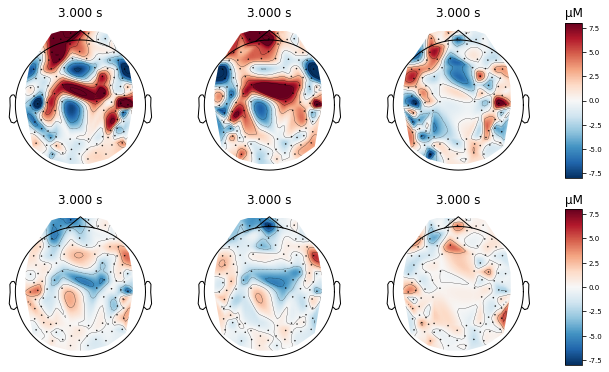

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-304-2021-11-01/2021-11-01_002.snirf
Reading 0 ... 6905  =      0.000 ...  1809.800 secs...


ic| 'Interpolate bad channels.'


Interpolating bad channels
    Automatic origin fit: head of radius 97172.5 mm


/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_48652/2552085766.py:20: RuntimeWarning: Estimated head size (97172.5 mm) exceeded 99th percentile for adult head size
/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_48652/2552085766.py:20: RuntimeWarning: (X, Y) fit (80.8, -20852.6) more than 20 mm from head frame origin
ic| 'Apply short channel regression.'


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 631 samples (165.385 sec)

Used Annotations descriptions: ['1', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '64', '65', '66', '67', '68', '69', '73', '74', '75', '76', '77', '78', 'Auditory/neg', 'Auditory/neu', 'Auditory/pos', 'Visual/neg', 'Visual/neu', 'Visual/pos']
Not setting metadata
Not setting metadata
384 matching events found
Setting baseline interval to [-2.0968, 0.0] sec
Applying ba

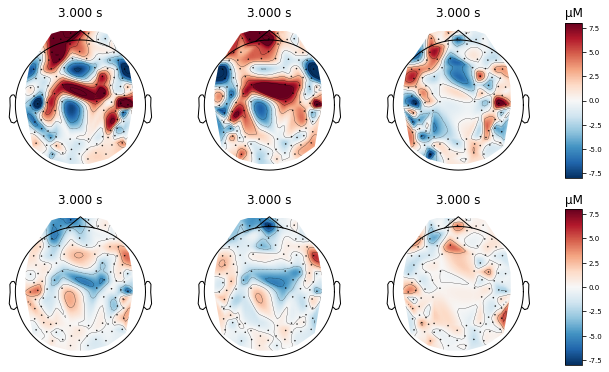

In [109]:
# preprocess only for loop
for idx, sub in enumerate(subjects[:2]):
    # Analyse data and return both ROI and channel results
    raw_haemo = preprocess_only(
        sub, idx
    )

In [ ]:
#renaming triggers
raw_intensity.annotations.rename({'70': 'Visual',
                        '71': 'Visual',
                        '72': 'Visual',
                        '61': 'Auditory',
                        '62': 'Auditory', 
                        '63': 'Auditory'})

# Individual analysis results
Note, it says group, but it is not group results yet. These results are per person. 

,ROI,Condition,Chroma,theta,se,t,dfe,p,ID,Visual_auditory
0,ROI_1,61,hbo,-27.832662,9.278473,-2.999703,82.0,0.003578,0,Auditory
2,ROI_2,61,hbo,-16.634738,11.705801,-1.421068,82.0,0.159089,0,Auditory
0,ROI_1,62,hbo,-4.336467,9.059609,-0.478659,82.0,0.633455,0,Auditory
2,ROI_2,62,hbo,-14.160358,11.491648,-1.232230,82.0,0.221385,0,Auditory
0,ROI_1,63,hbo,4.477161,8.997792,0.497584,82.0,0.620109,0,Auditory
...,...,...,...,...,...,...,...,...,...,...
2,ROI_2,70,hbo,-32.067234,14.963088,-2.143089,83.0,0.035034,16,Visual
0,ROI_1,71,hbo,-2.669738,11.823049,-0.225808,83.0,0.821906,16,Visual
2,ROI_2,71,hbo,1.280481,14.652714,0.087389,83.0,0.930573,16,Visual
0,ROI_1,72,hbo,7.208959,12.377536,0.582423,83.0,0.561861,16,Visual


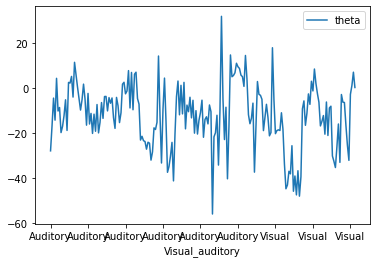

In [67]:
grp_results = df_roi.query("Condition in ['70', '71', '72', '61', '62', '63']")
grp_results = grp_results.query("Chroma in ['hbo']")

#making a new column
grp_results["Visual_auditory"] = np.where(grp_results.Condition.isin(['70', '71', '72']), "Visual", "Auditory")
grp_results.head()

grp_results.plot(x = "Visual_auditory", y = "theta")

grp_results

# GLM 

In [ ]:
grp_results = df_roi.query("Condition in ['70', '71', '72', '61', '62', '63']")


#making a new column
grp_results["Visual_auditory"] = np.where(grp_results.Condition.isin(['70', '71', '72']), "Visual", "Auditory")
grp_results.head()

#model
roi_model = smf.mixedlm("theta ~ -1 + ROI:Visual_auditory:Chroma",
                        grp_results, groups=grp_results["ID"]).fit(method='nm')
roi_model.summary()
#grp_results

In [48]:
# Saving results
grp_results.to_csv("group_results.csv")

## Epochs   

In [59]:
#renaming triggers
raw_haemo.annotations.rename({'70': 'Visual',
                        '71': 'Visual',
                        '72': 'Visual',
                        '61': 'Auditory',
                        '62': 'Auditory', 
                        '63': 'Auditory'})


<Annotations | 384 segments: 1 (96), 43 (8), 44 (8), 45 (8), 46 (8), 47 ...>

In [32]:
# getting events
events, event_dict = mne.events_from_annotations(raw_haemo)

# signals which are unlikely large are removed
# default 80e-6
# maybe it should be 250e-6
#reject_criteria = dict(hbo=hbo_limit)
tmin, tmax = -2, 7 #time

# getting epochs
epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                    tmin=tmin, tmax=tmax,
                    #reject=reject_criteria, 
                    reject_by_annotation=True,
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=None, verbose=True) 


Used Annotations descriptions: ['1', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '64', '65', '66', '67', '68', '69', '73', '74', '75', '76', '77', '78', 'Auditory', 'Visual']
Not setting metadata
Not setting metadata
384 matching events found
Setting baseline interval to [-2.0968, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 384 events and 36 original time points ...
0 bad epochs dropped


# Plotting
## Entire head

<AxesSubplot:title={'center':'Contrast'}>

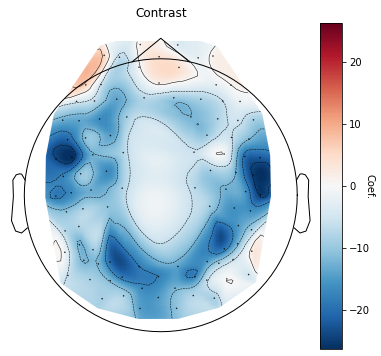

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
con_summary = df_con.query("Chroma in ['hbo']")

#rois = dict(
#        ROI_1=picks_pair_to_idx(raw_haemo, roi_1, on_missing='ignore'),
#        ROI_2=picks_pair_to_idx(raw_haemo, roi_2, on_missing='ignore'))


# Run group level model and convert to dataframe
con_model = smf.mixedlm("effect ~ -1 + ch_name:Chroma",
                        con_summary, groups=con_summary["ID"]).fit(method='nm')
con_model_df = statsmodels_to_results(con_model,
                                      order=raw_haemo.copy().pick(
                                          picks="hbo").ch_names)

#con_model_df['Coef.'] = -con_model_df['Coef.']

plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
                    con_model_df, colorbar=True, axes=axes)

In [75]:
?df_con.query

Signature: df_con.query(expr: 'str', inplace: 'bool' = False, **kwargs)
Docstring:
Query the columns of a DataFrame with a boolean expression.

Parameters
----------
expr : str
    The query string to evaluate.

    You can refer to variables
    in the environment by prefixing them with an '@' character like
    ``@a + b``.

    You can refer to column names that are not valid Python variable names
    by surrounding them in backticks. Thus, column names containing spaces
    or punctuations (besides underscores) or starting with digits must be
    surrounded by backticks. (For example, a column named "Area (cm^2)" would
    be referenced as ```Area (cm^2)```). Column names which are Python keywords
    (like "list", "for", "import", etc) cannot be used.

    For example, if one of your columns is called ``a a`` and you want
    to sum it with ``b``, your query should be ```a a` + b``.

    .. versionadded:: 0.25.0
        Backtick quoting introduced.

    .. versionadded:: 1.0.0
    

## ROI

In [34]:
topomap_args = dict(extrapolate='local')

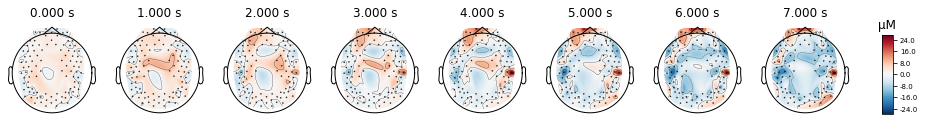

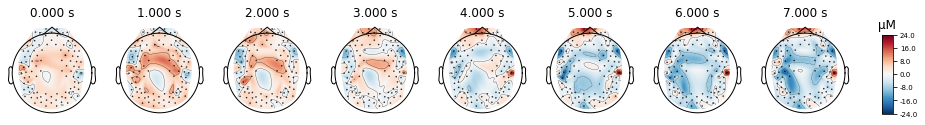

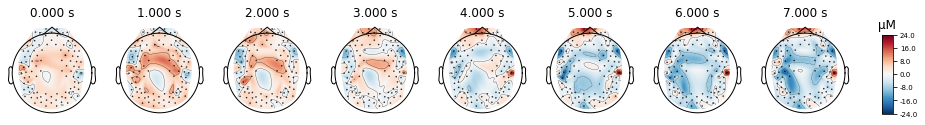

In [43]:
times = np.arange(0, 8, 1)

epochs['Visual'].average(picks='hbo').plot_topomap(
    times=times, **topomap_args)
epochs['Auditory'].average(picks='hbo').plot_topomap(
    times=times, **topomap_args)

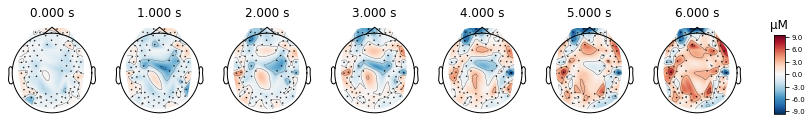

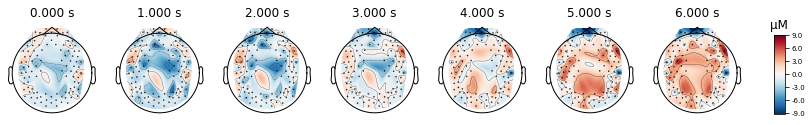

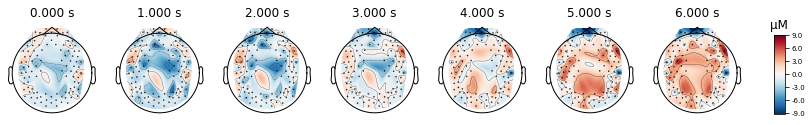

In [38]:
epochs['Visual'].average(picks='hbr').plot_topomap(
    times=times, **topomap_args)
epochs['Auditory'].average(picks='hbr').plot_topomap(
    times=times, **topomap_args)

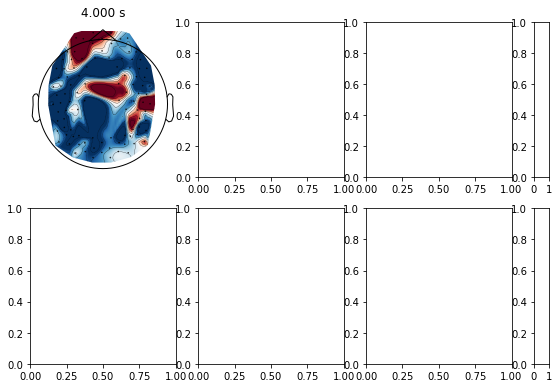

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 5),
                         gridspec_kw=dict(width_ratios=[1, 1, 1, 0.1]))
vmin, vmax, ts = -2.1, 7, 4.0

evoked_vis = epochs['Visual'].average()
evoked_aud = epochs['Auditory'].average()

evoked_vis.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 0],
                         vmin=vmin, vmax=vmax, colorbar=False,
                         **topomap_args)
evoked_vis.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 0],
                         vmin=vmin, vmax=vmax, colorbar=False,
                         **topomap_args)
evoked_aud.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 1],
                          vmin=vmin, vmax=vmax, colorbar=False,
                          **topomap_args)
evoked_aud.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 1],
                          vmin=vmin, vmax=vmax, colorbar=False,
                          **topomap_args)

evoked_diff = mne.combine_evoked([evoked_vis, evoked_aud], weights=[1, -1])

evoked_diff.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 2:],
                         vmin=vmin, vmax=vmax, colorbar=True,
                         **topomap_args)
evoked_diff.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 2:],
                         vmin=vmin, vmax=vmax, colorbar=True,
                         **topomap_args)

for column, condition in enumerate(
        ['Visual', 'Auditory', 'Vis-aud']):
    for row, chroma in enumerate(['HbO', 'HbR']):
        axes[row, column].set_title('{}: {}'.format(chroma, condition))
fig.tight_layout()